In [1]:
import os
import time
from dask.distributed import Client, as_completed
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

## Get and massage portfolio data

In [2]:
ticker_histories_filename = os.path.join("input", "ticker_histories.csv")
ticker_histories_df = pd.read_csv(ticker_histories_filename)
ticker_histories_df["datetime"] = pd.to_datetime(
    ticker_histories_df["timestamp"], unit="ms"
).dt.tz_localize(None)
ticker_histories_df.set_index("datetime", inplace=True)
ticker_histories_df.drop("timestamp", axis=1, inplace=True)
ticker_histories_df.sort_index(inplace=True)
ticker_histories_df

ticker      open      high       low     close  \
datetime                                                             
2020-04-01 04:00:00   AMZN   96.6485   97.2480   94.6500   95.3850   
2020-04-01 04:00:00   MSFT  153.0000  157.7500  150.8200  152.1100   
2020-04-01 04:00:00   AAPL   61.6250   62.1800   59.7825   60.2275   
2020-04-01 04:00:00   GOOG   56.1000   56.4845   54.8725   55.2810   
2020-04-01 04:00:00   NVDA    6.3913    6.5383    6.0320    6.0768   
...                    ...       ...       ...       ...       ...   
2025-03-13 04:00:00   AAPL  215.9500  216.8394  208.4200  209.6800   
2025-03-13 04:00:00   GOOG  167.9800  168.1200  164.0700  164.7300   
2025-03-13 04:00:00   AMZN  198.1650  198.8799  191.8200  193.8900   
2025-03-13 04:00:00   NVDA  117.0300  117.7600  113.7900  115.5800   
2025-03-13 04:00:00   TSLA  248.1250  248.2900  232.6000  240.6800   

                          volume      vwap  transactions  
datetime                                                  
2020-04-01 04:00:00   82437500.0   95.8985        141417  
2020-04-01 04:00:00   57969926.0  153.7717        531817  
2020-04-01 04:00:00  176046552.0   60.9782        460605  
2020-04-01 04:00:00   46883460.0   55.6376         71423  
2020-04-01 04:00:00  656913120.0    6.2836        185913  
...                          ...       ...           ...  
2025-03-13 04:00:00   59752532.0  212.0980        768619  
2025-03-13 04:00:00   14841144.0  165.4467        253905  
2025-03-13 04:00:00   39427497.0  194.3506        588340  
2025-03-13 04:00:00  293604451.0  116.0288       2246248  
2025-03-13 04:00:00  113767792.0  239.0263       1535862  

[7464 rows x 8 columns]

In [3]:
adj_close_df = ticker_histories_df.reset_index().pivot(
    index="datetime", columns="ticker", values="close"
)
adj_close_df.index = pd.DatetimeIndex(adj_close_df.index)
adj_close_df.index = pd.DatetimeIndex(
    [dt.replace(hour=17, minute=0, second=0) for dt in adj_close_df.index]
)
adj_close_df

ticker                   AAPL      AMZN      GOOG    MSFT      NVDA      TSLA
2020-04-01 17:00:00   60.2275   95.3850   55.2810  152.11    6.0768   32.1040
2020-04-02 17:00:00   61.2325   95.9415   56.0420  155.26    6.3868   30.2980
2020-04-03 17:00:00   60.3525   95.3295   54.8940  153.83    6.0977   32.0007
2020-04-06 17:00:00   65.6175   99.8795   59.3460  165.27    6.7100   34.4160
2020-04-07 17:00:00   64.8575  100.5800   59.3255  163.49    6.4758   36.3633
...                       ...       ...       ...     ...       ...       ...
2025-03-07 17:00:00  239.0700  199.2500  175.7500  393.31  112.6900  262.6700
2025-03-10 17:00:00  227.4800  194.5400  167.8100  380.16  106.9800  222.1500
2025-03-11 17:00:00  220.8400  196.5900  165.9800  380.45  108.7600  230.5800
2025-03-12 17:00:00  216.9800  198.8900  169.0000  383.27  115.7400  248.0900
2025-03-13 17:00:00  209.6800  193.8900  164.7300  378.77  115.5800  240.6800

[1244 rows x 6 columns]

In [4]:
ticker_decomps = {}
for ticker in adj_close_df.columns:
    adj_close = adj_close_df.loc[:, ticker]
    adj_close = adj_close.asfreq("B", method="ffill")
    components = tsa.seasonal_decompose(adj_close, model="additive")
    adj_close_decomp_df = (
        adj_close.to_frame("original")
        .assign(trend=components.trend)
        .assign(seasonal=components.seasonal)
        .assign(residual=components.resid)
    )
    ticker_decomps[ticker] = adj_close_decomp_df

## Plot the trends for each ticker

In [5]:
def plot_decomp(df, title):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 8))
    axs[0].plot(df["original"])
    axs[0].set_title("Original")
    axs[1].plot(df["trend"], color="orange")
    axs[1].set_title("Trend")
    axs[2].plot(df["seasonal"], color="green")
    axs[2].set_title("Seasonal")
    axs[3].plot(df["residual"], color="red")
    axs[3].set_title("Residual")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()

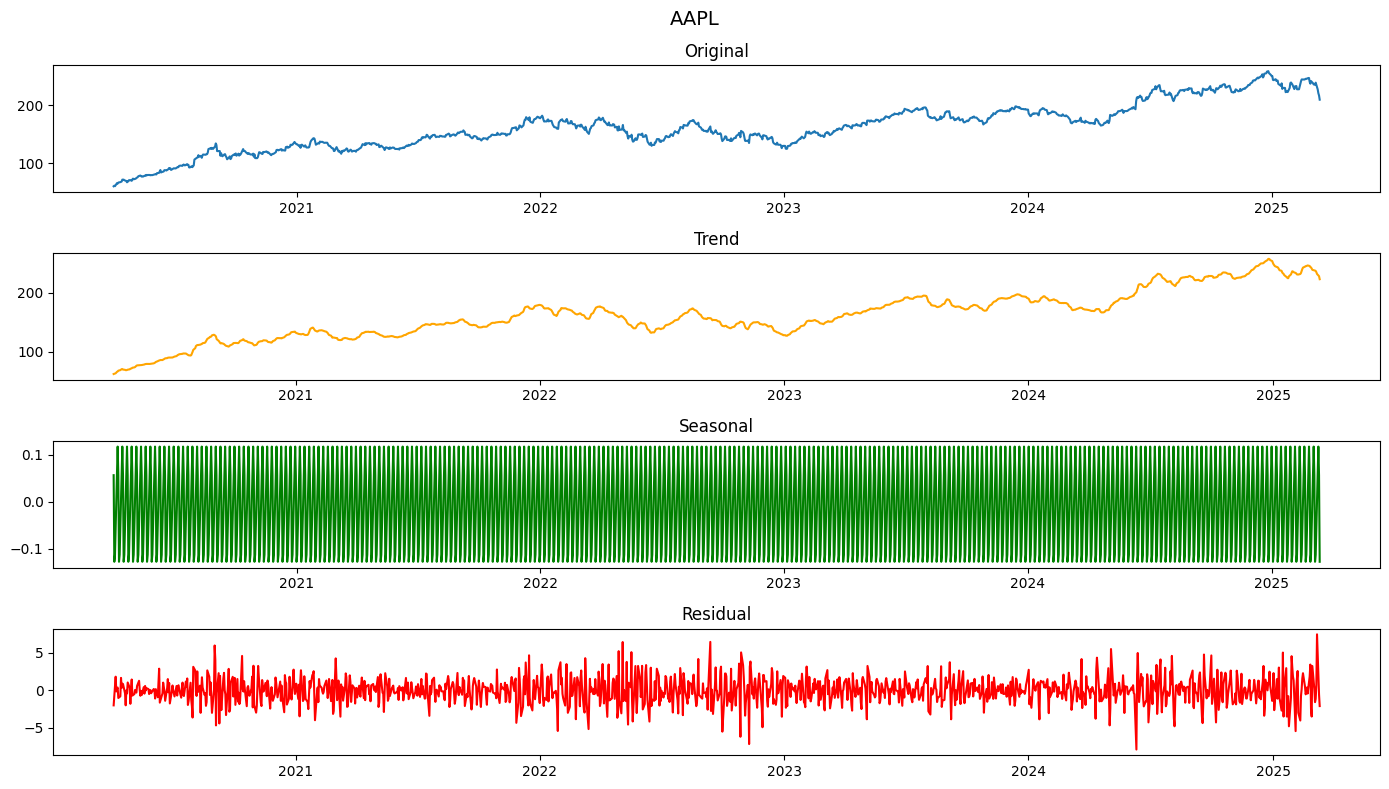

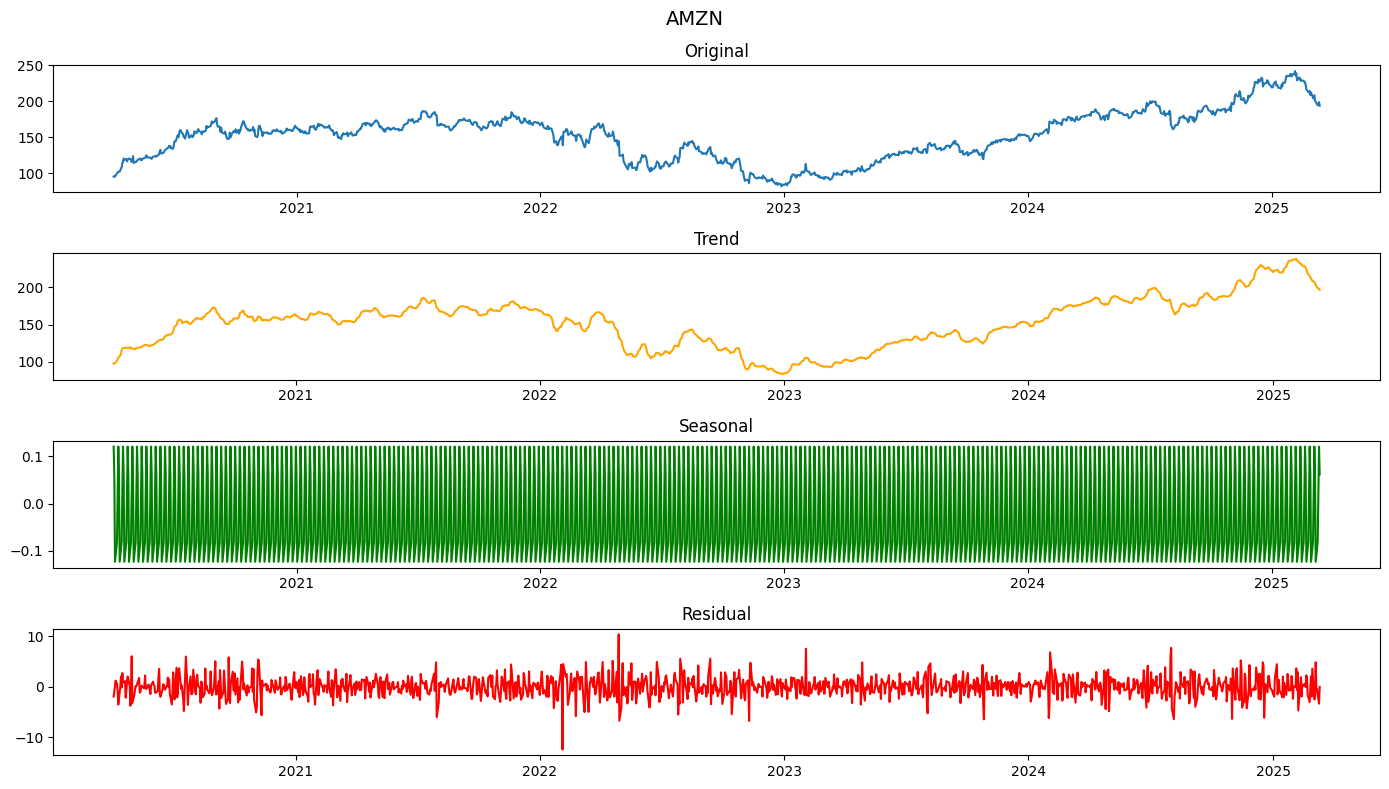

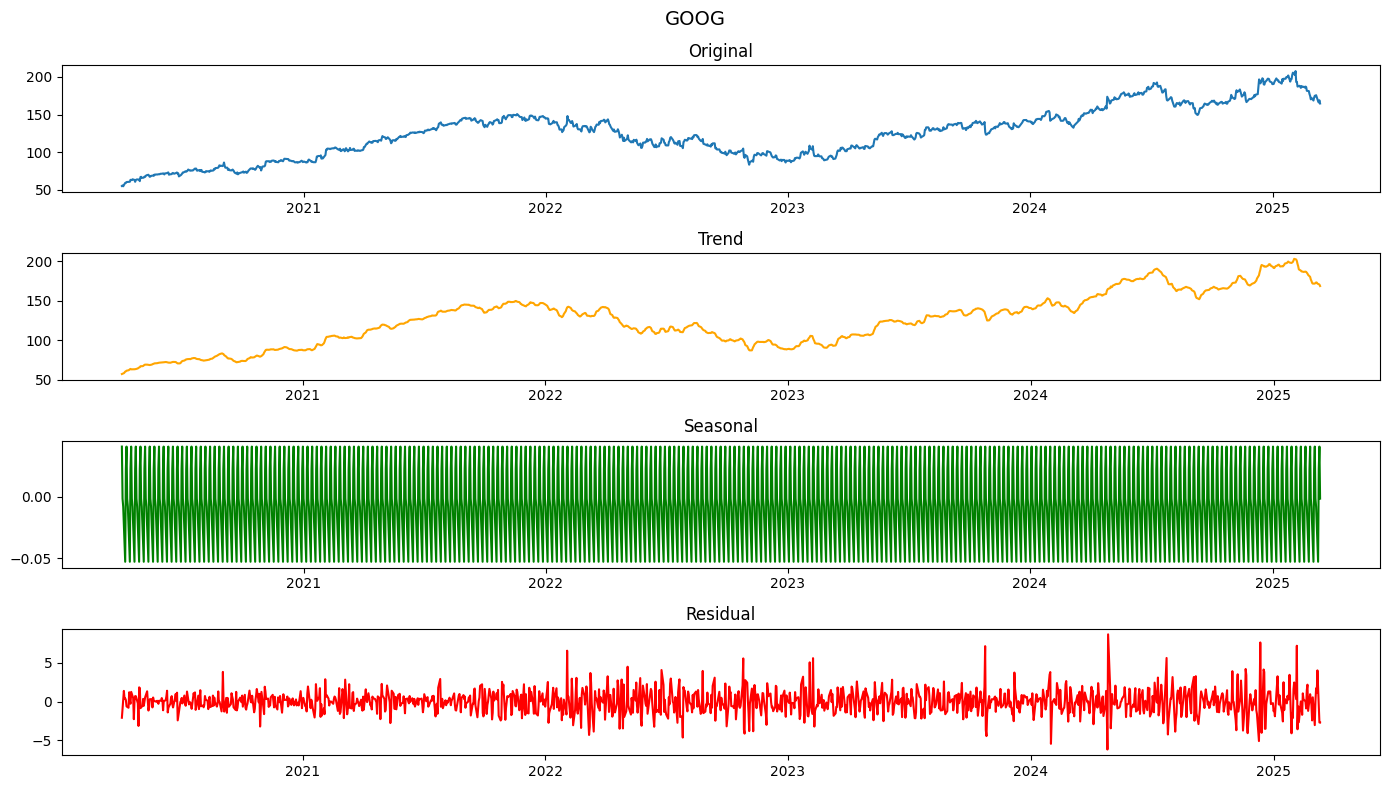

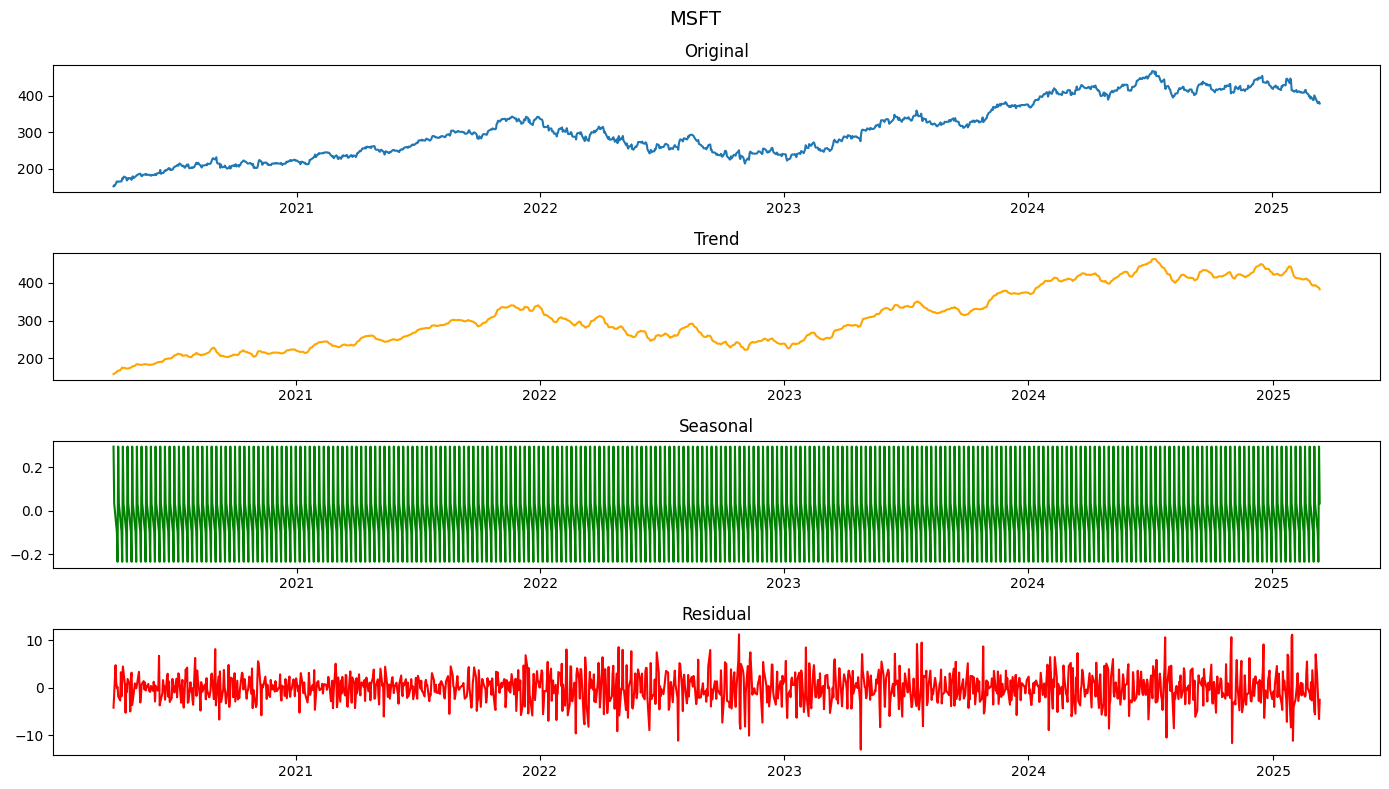

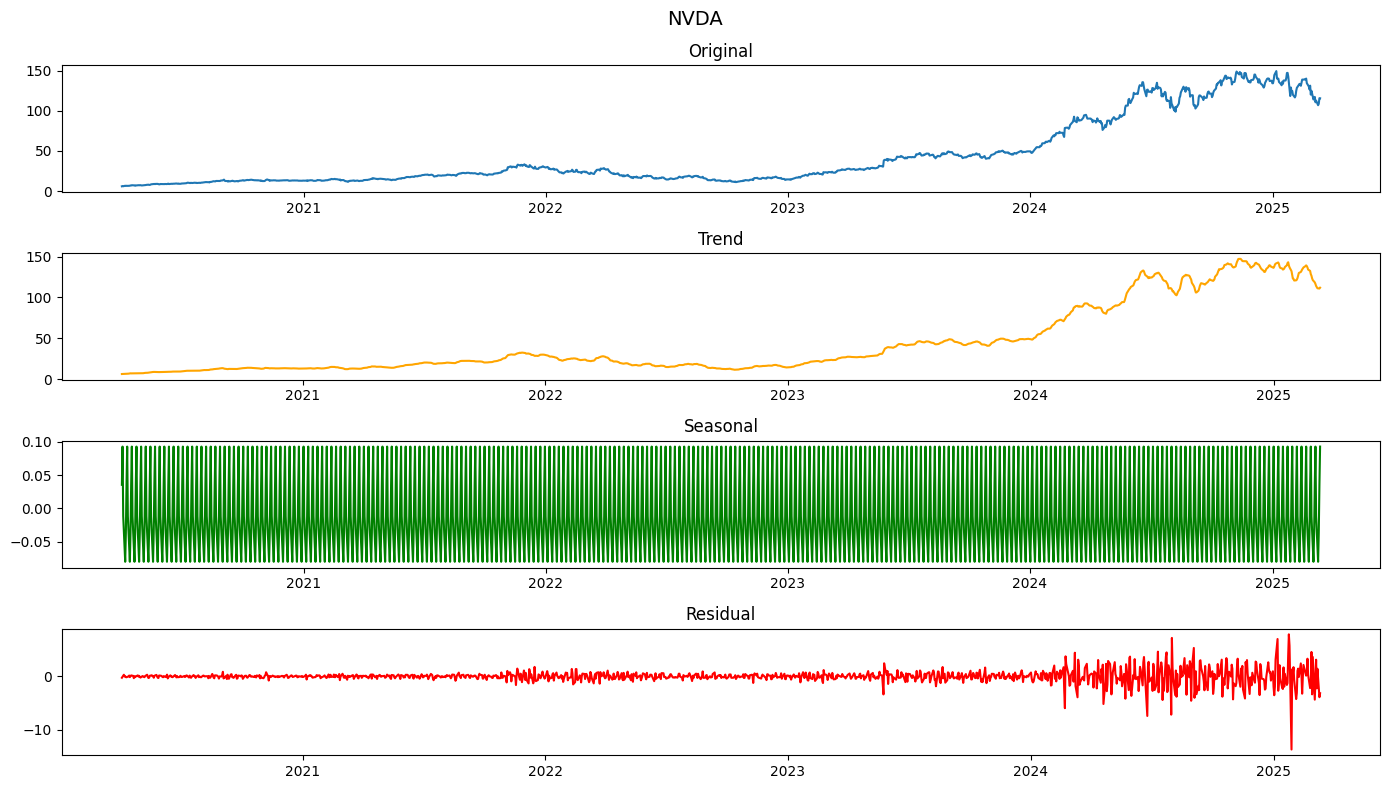

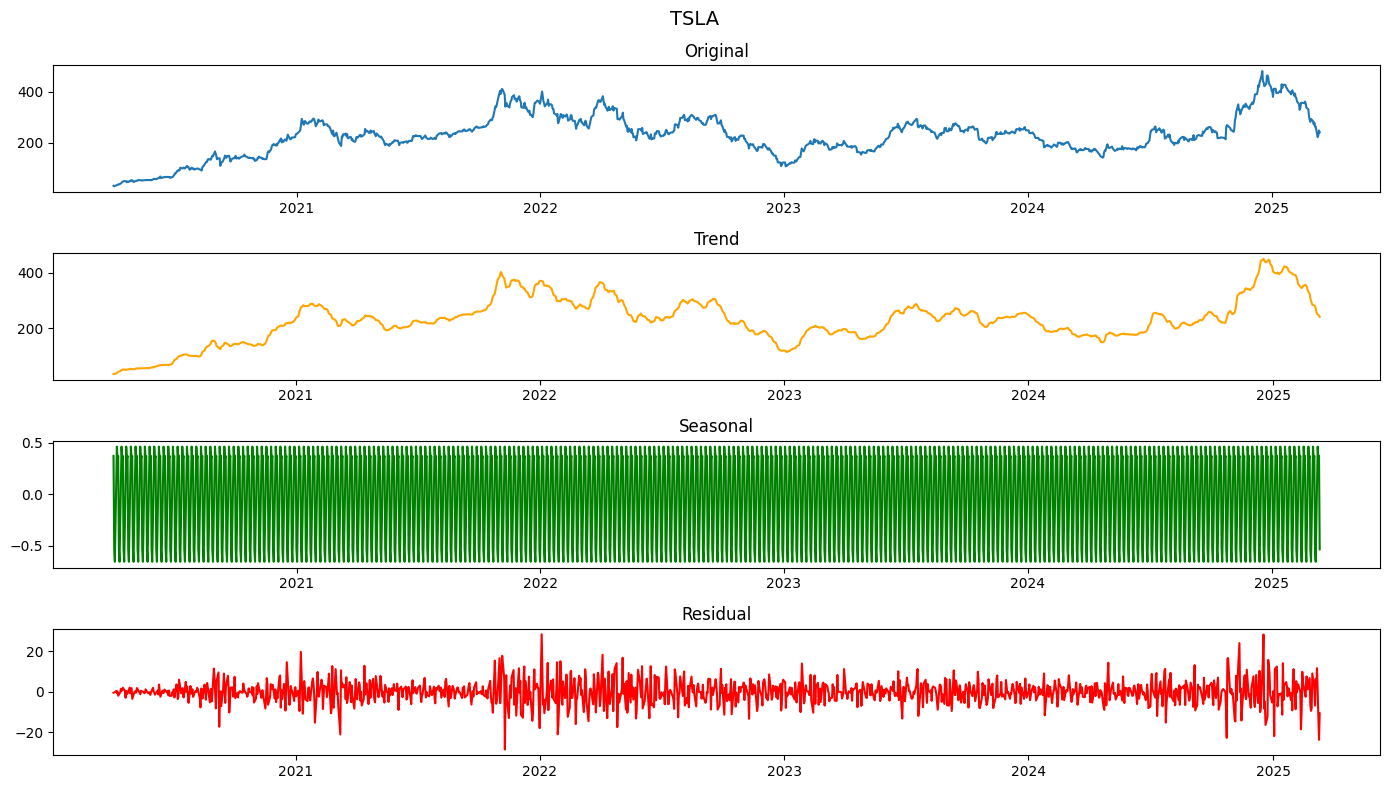

In [6]:
for ticker, decomp in ticker_decomps.items():
    plot_decomp(decomp, ticker)

## Differencing and log transforms

In [7]:
ticker_diffs = {}
for ticker in adj_close_df.columns:
    adj_close = adj_close_df.loc[:, ticker]
    adj_close_log = np.log(adj_close)
    adj_close_log_diff_1 = adj_close_log.diff()
    diff_df = (
        adj_close.to_frame("original")
        .assign(log=adj_close_log)
        .assign(log_diff_1=adj_close_log_diff_1)
    )
    ticker_diffs[ticker] = diff_df

In [8]:
def plot_log_diffs(df, title):
    original_adf_p = tsa.adfuller(df["original"].dropna())[1]
    log_adf_p = tsa.adfuller(df["log"].dropna())[1]
    log_diff_1_adf_p = tsa.adfuller(df["log_diff_1"].dropna())[1]
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))
    axs[0].plot(df["original"])
    axs[0].set_title(f"original, p={original_adf_p:.4f}")
    axs[1].plot(df["log"], color="orange")
    axs[1].set_ylabel("log")
    axs[1].set_title(f"log, p={log_adf_p:.4f}")
    axs[2].plot(df["log_diff_1"], color="green")
    axs[2].set_ylabel("log, diff")
    axs[2].set_title(f"log diff, p={log_diff_1_adf_p:.4f}")
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

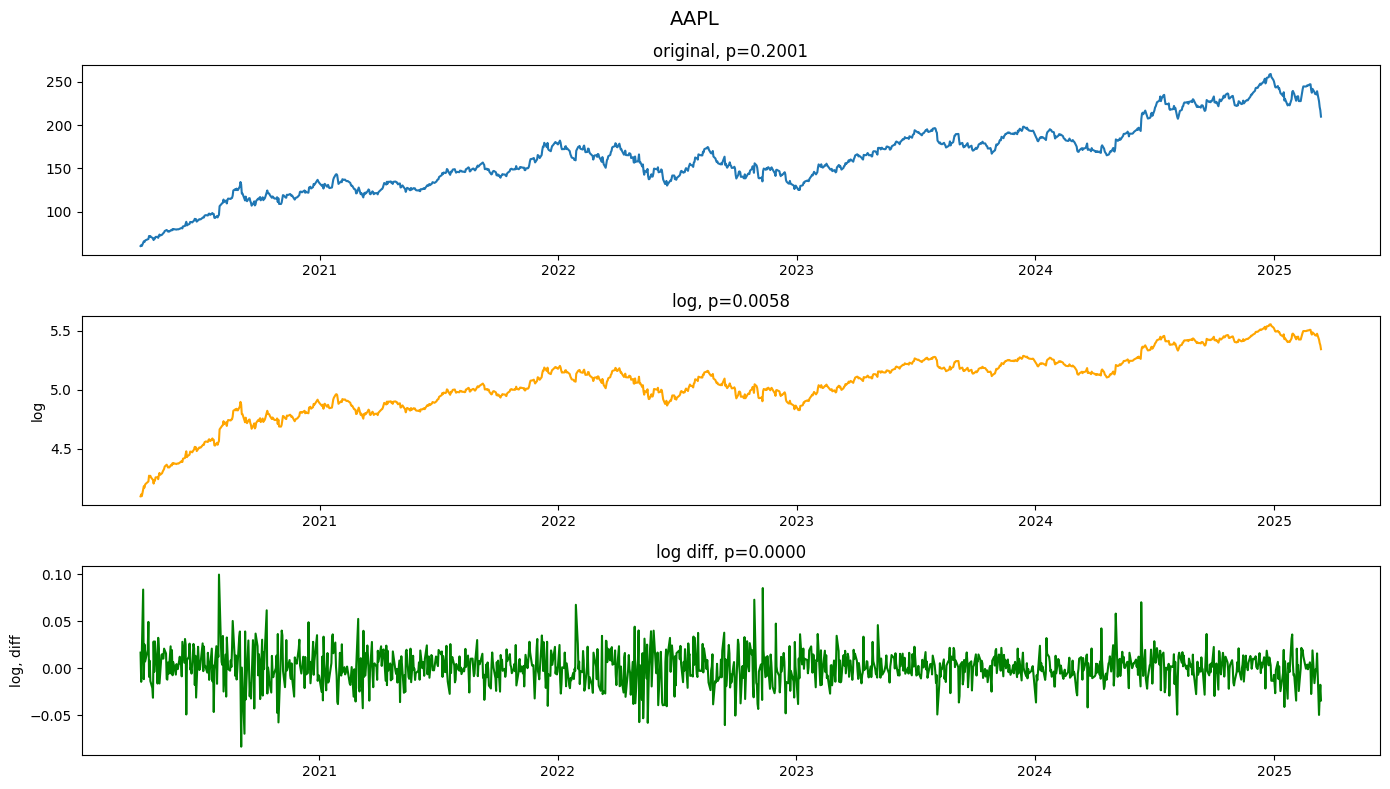

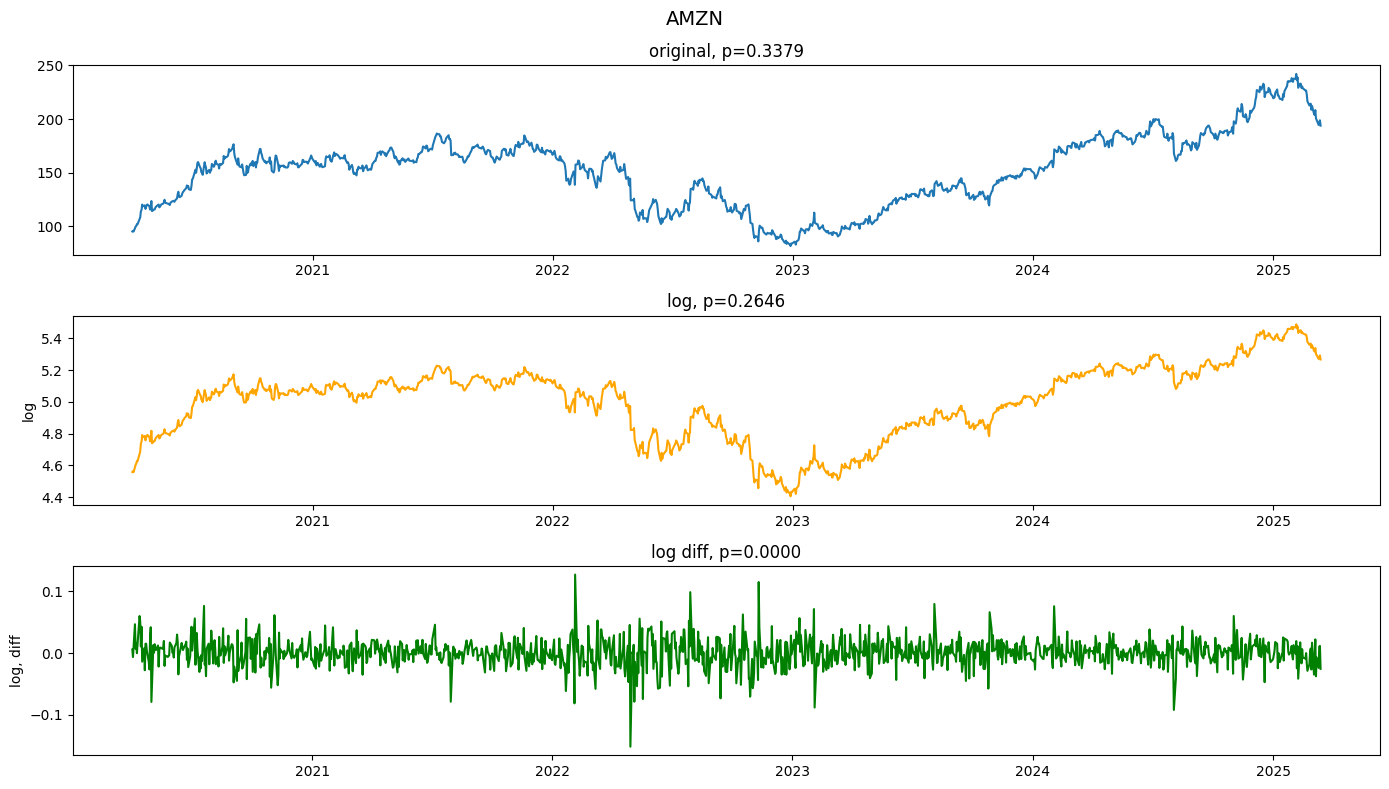

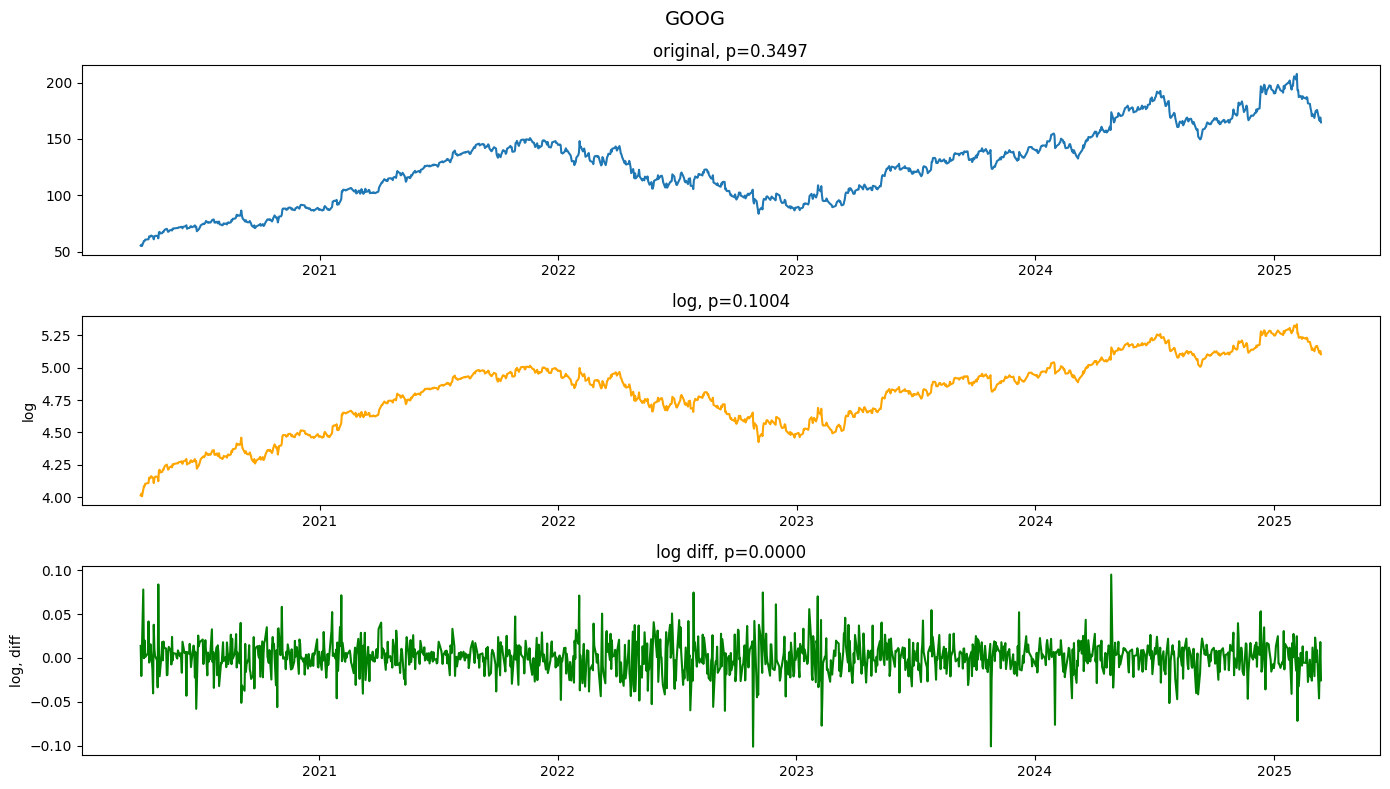

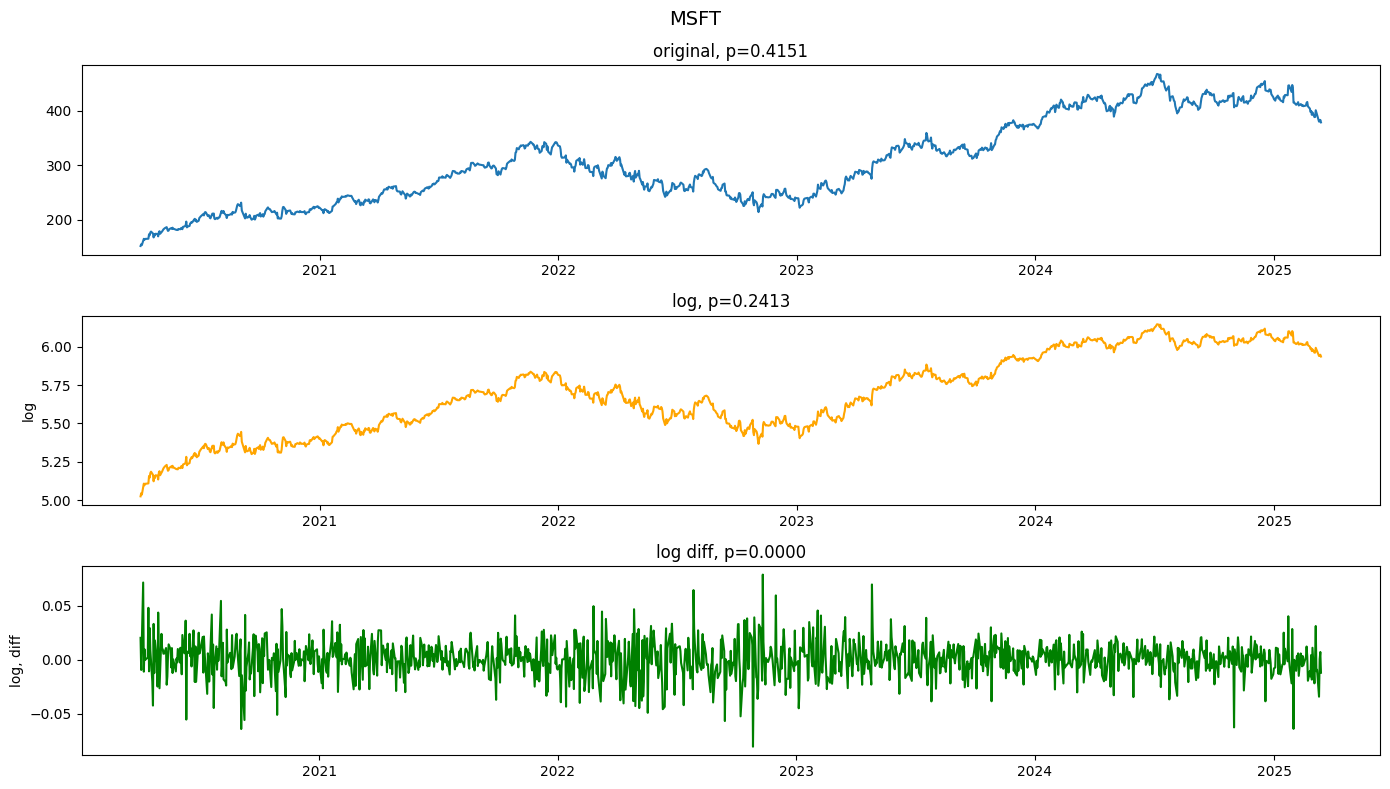

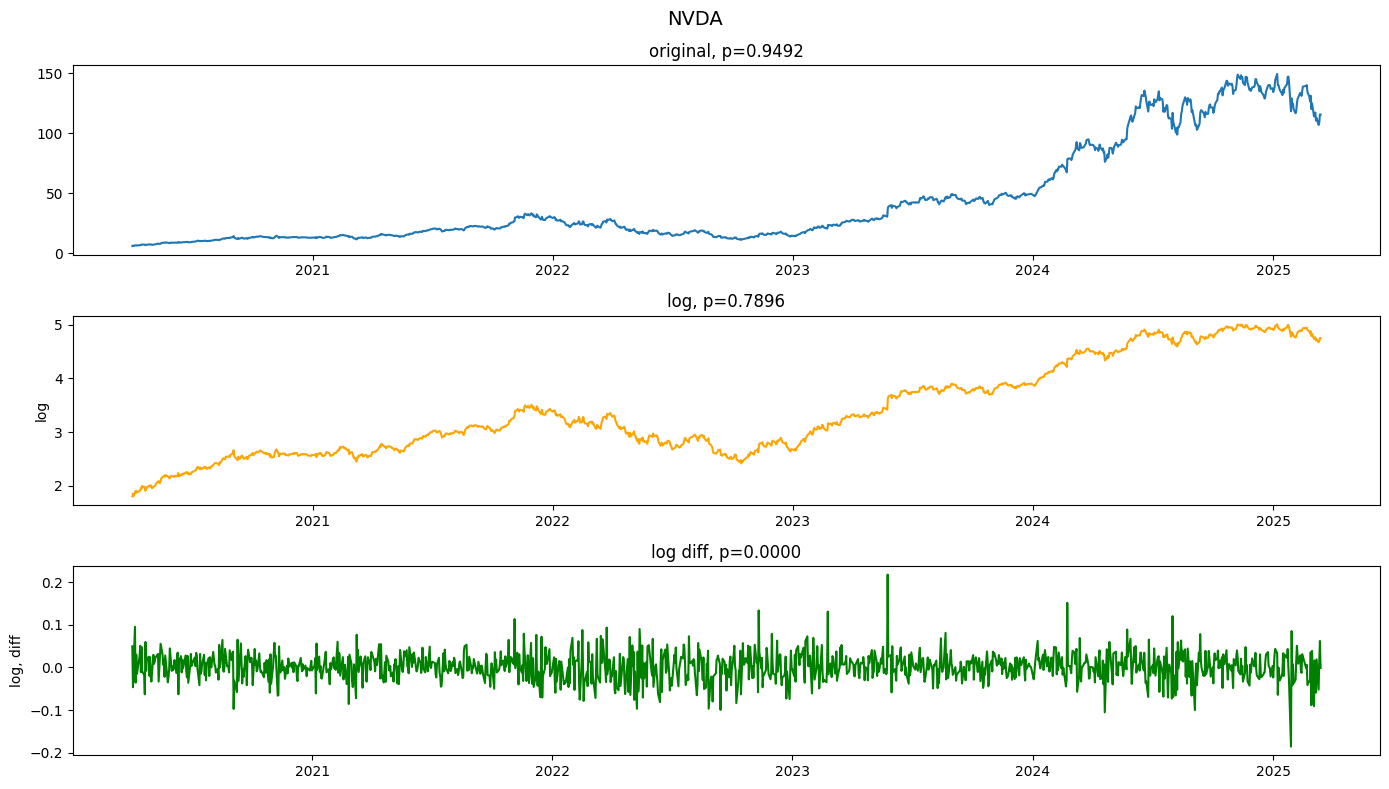

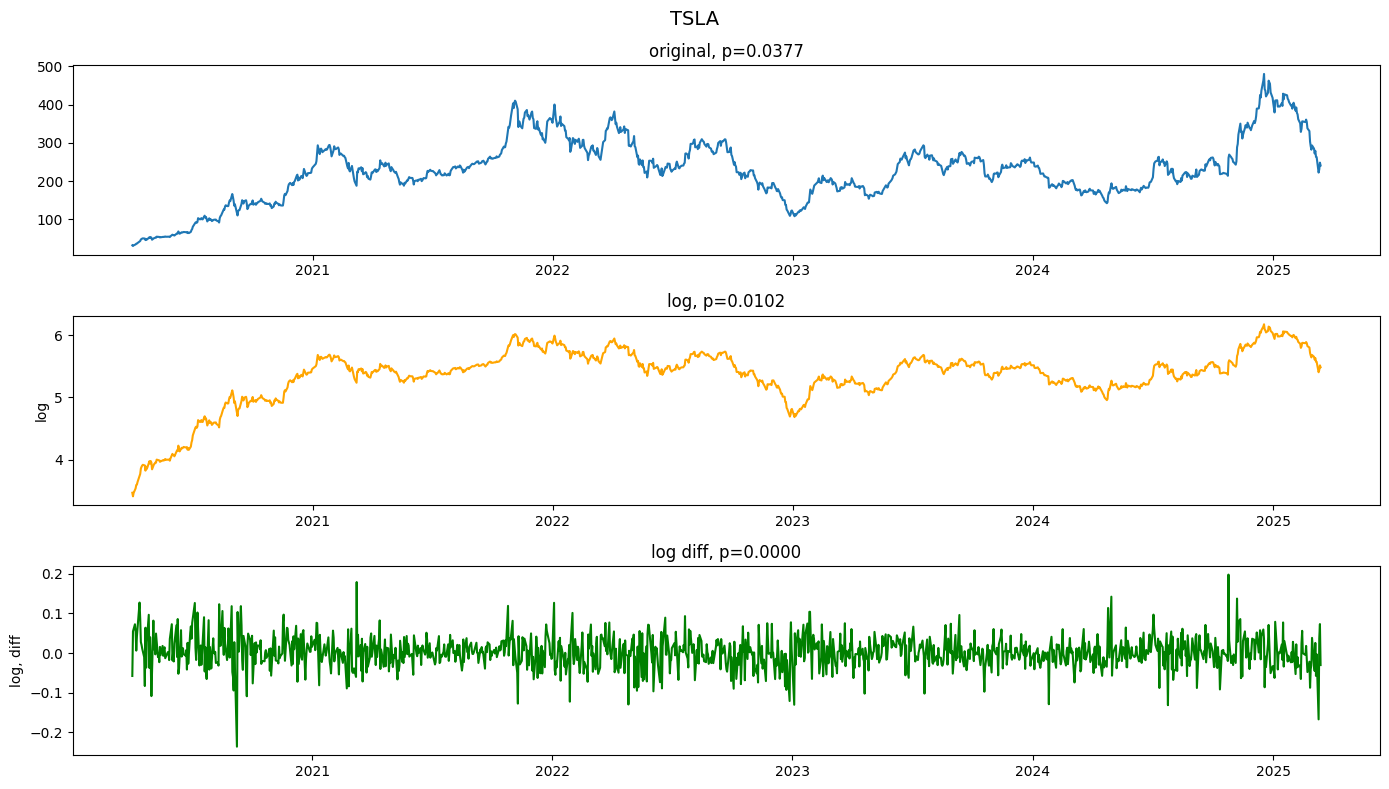

In [9]:
for ticker, diff in ticker_diffs.items():
    plot_log_diffs(diff, ticker)

## Fit ARIMA models

### First AAPL

Function to fit ARIMA model.

In [ ]:
def arima_fit(task):
    time_series = task["time_series"]
    p = task["p"]
    q = task["q"]
    diff = task["diff"]
    train_size = task["train_size"]
    y_true = time_series[train_size:]
    y_pred = []
    bics = []
    aics = []
    n_convergence_errors = 0
    n_stationarity_errors = 0
    for bound in range(train_size, len(time_series)):
        train_set = time_series.iloc[bound - train_size : bound]
        try:
            model = tsa.ARIMA(endog=train_set, order=(p, diff, q)).fit()
        except LinAlgError:
            n_convergence_errors += 1
        except ValueError:
            n_stationarity_errors += 1
        forecast = model.forecast(steps=1)
        y_pred.append(forecast.iloc[0])
        aics.append(model.aic)
        bics.append(model.bic)
    df = (
        pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
        .replace(np.inf, np.nan)
        .dropna()
    )
    rmse = np.sqrt(mean_squared_error(y_true=df["y_true"], y_pred=df["y_pred"]))
    result = {
        "p": p,
        "q": q,
        "rmse": rmse,
        "mean_aic": np.mean(aics),
        "mean_bic": np.mean(bics),
        "n_convergence_errors": n_convergence_errors,
        "n_stationarity_errors": n_stationarity_errors,
    }
    return result

Process pool executor to train on log(AAPL) data.

In [11]:
aapl = adj_close_df["AAPL"]
aapl_log = np.log(aapl[aapl.index > pd.Timestamp('2024-03-18')])

In [ ]:
tasks = []
for p in range(5):
    for q in range(5):
        if p == 0 and q == 0:
            continue
        tasks.append({
            "time_series": aapl_log,
            "diff": 1,
            "train_size": 120,
            "p": p,
            "q": q,
        })

dask_client = Client()
futures = [dask_client.submit(arima_fit, task) for task in tasks]
arima_fit_results = []
for future in tqdm(as_completed(futures), total=len(futures), desc="Processing", unit="task"):
    arima_fit_results.append(future.result())
dask_client.close()
arima_fit_df = pd.DataFrame(arima_fit_results)
arima_fit_results

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55730 instead
  warnings.warn(
Processing:   0%|          | 0/24 [00:00<?, ?task/s]/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model

120    5.397162
dtype: float64
120    5.396992
dtype: float64
120    5.397819
dtype: float64
120    5.397231
dtype: float64
120    5.397764
dtype: float64
120    5.393943
dtype: float64
120    5.396998
dtype: float64
120    5.394237
dtype: float64
120    5.397221
dtype: float64
120    5.397062
dtype: float64
120    5.397043
dtype: float64
120    5.397777
dtype: float64
120    5.406307
dtype: float64
120    5.393984
dtype: float64
120    5.397767
dtype: float64
120    5.397555
dtype: float64
120    5.397797
dtype: float64
120    5.397846
dtype: float64
120    5.397291
dtype: float64
120    5.406197
dtype: float64
120    5.394804
dtype: float64
120    5.393972
dtype: float64
120    5.406164
dtype: float64
120    5.39669
dtype: float64
120    5.393938
dtype: float64
120    5.405925
dtype: float64
120    5.397812
dtype: float64
120    5.397986
dtype: float64
120    5.39712
dtype: float64
120    5.406195
dtype: float64
120    5.395025
dtype: float64
120    5.394411
dtype: float64
120    5.3

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No suppor

120    5.422066
dtype: float64
120    5.40614
dtype: float64
120    5.422167
dtype: float64
120    5.37908
dtype: float64
120    5.426862
dtype: float64
120    5.393972
dtype: float64
120    5.40401
dtype: float64
120    5.421854
dtype: float64
120    5.394404
dtype: float64
120    5.379153
dtype: float64
120    5.427206
dtype: float64
120    5.405089
dtype: float64
120    5.404866
dtype: float64
120    5.397802
dtype: float64
120    5.405677
dtype: float64
120    5.421663
dtype: float64
120    5.394296
dtype: float64
120    5.374633
dtype: float64
120    5.405782
dtype: float64
120    5.427836
dtype: float64
120    5.435863
dtype: float64
120    5.427607
dtype: float64
120    5.428514
dtype: float64
120    5.406306
dtype: float64
120    5.405937
dtype: float64
120    5.375258
dtype: float64
120    5.428252
dtype: float64
120    5.39777
dtype: float64
120    5.375249
dtype: float64
120    5.40693
dtype: float64
120    5.379807
dtype: float64
120    5.453014
dtype: float64
120    5.3791

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.403712
dtype: float64
120    5.419934
dtype: float64
120    5.420163
dtype: float64
120    5.43665
dtype: float64
120    5.422107
dtype: float64
120    5.407177
dtype: float64
120    5.403424
dtype: float64
120    5.433827
dtype: float64
120    5.422227
dtype: float64
120    5.436317
dtype: float64
120    5.402903
dtype: float64
120    5.402455
dtype: float64
120    5.427174
dtype: float64
120    5.433481
dtype: float64
120    5.380223
dtype: float64
120    5.428041
dtype: float64
120    5.444117
dtype: float64
120    5.428485
dtype: float64
120    5.427237
dtype: float64
120    5.421501
dtype: float64
120    5.426824
dtype: float64
120    5.453044
dtype: float64
120    5.379055
dtype: float64
120    5.376242
dtype: float64
120    5.42184
dtype: float64
120    5.444302
dtype: float64
120    5.419796
dtype: float64
120    5.455017
dtype: float64120    5.454539
dtype: float64

120    5.375674
dtype: float64
120    5.427001
dtype: float64
120    5.421794
dtype: float64
120    5.4

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

120    5.427393
dtype: float64
120    5.421712
dtype: float64
120    5.453108
dtype: float64
120    5.429003
dtype: float64
120    5.436639
dtype: float64
120    5.440719
dtype: float64
120    5.440967
dtype: float64
120    5.400038
dtype: float64
120    5.440528
dtype: float64
120    5.427728
dtype: float64
120    5.433807
dtype: float64
120    5.444325
dtype: float64
120    5.420006
dtype: float64
120    5.427168
dtype: float64120    5.444305
dtype: float64
120    5.452972
dtype: float64
120    5.400315
dtype: float64
120    5.453054
dtype: float64
120    5.377221
dtype: float64
120    5.453026
dtype: float64

120    5.4177
dtype: float64
120    5.401133
dtype: float64
120    5.42088
dtype: float64
120    5.453696
dtype: float64
120    5.444153
dtype: float64
120    5.427804
dtype: float64
120    5.424198
dtype: float64
120    5.453951
dtype: float64
120    5.428318
dtype: float64
120    5.437893
dtype: float64
120    5.41803
dtype: float64
120    5.418859
dtype: float64
120    5.437

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No suppor

120    5.399875
dtype: float64120    5.412672
dtype: float64

120    5.43242
dtype: float64
120    5.416858
dtype: float64
120    5.424159
dtype: float64
120    5.43411
dtype: float64
120    5.399899
dtype: float64
120    5.424189
dtype: float64
120    5.431112
dtype: float64
120    5.430356
dtype: float64
120    5.463218
dtype: float64
120    5.427171
dtype: float64
120    5.418818
dtype: float64
120    5.415379
dtype: float64
120    5.419628
dtype: float64
120    5.440707
dtype: float64
120    5.430001
dtype: float64
120    5.412039
dtype: float64
120    5.427183
dtype: float64
120    5.440551
dtype: float64
120    5.413023
dtype: float64
120    5.430163
dtype: float64
120    5.418906
dtype: float64
120    5.420877
dtype: float64120    5.429452
dtype: float64
120    5.43062
dtype: float64

120    5.444309
dtype: float64
120    5.416865
dtype: float64
120    5.433851
dtype: float64
120    5.418668
dtype: float64120    5.451675
dtype: float64

120    5.431737
dtype: float64
120    5.45

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.419469
dtype: float64
120    5.447565
dtype: float64
120    5.469928
dtype: float64
120    5.425733
dtype: float64
120    5.419988
dtype: float64
120    5.409558
dtype: float64
120    5.479362
dtype: float64
120    5.43002
dtype: float64
120    5.492295
dtype: float64
120    5.436499
dtype: float64
120    5.43382
dtype: float64
120    5.429652
dtype: float64
120    5.445453
dtype: float64
120    5.431441
dtype: float64
120    5.418427
dtype: float64
120    5.405732
dtype: float64
120    5.425883
dtype: float64
120    5.493193
dtype: float64120    5.459929
dtype: float64

120    5.433516
dtype: float64
120    5.450958
dtype: float64
120    5.493235
dtype: float64
120    5.466162
dtype: float64
120    5.437855
dtype: float64
120    5.436456
dtype: float64
120    5.427967
dtype: float64
120    5.455113
dtype: float64
120    5.451012
dtype: float64
120    5.492352
dtype: float64
120    5.423752
dtype: float64
120    5.427236
dtype: float64
120    5.509193
dtype: float64
120    5.4

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

120    5.493161
dtype: float64
120    5.536039
dtype: float64
120    5.432042
dtype: float64
120    5.419087
dtype: float64
120    5.44055
dtype: float64
120    5.512622
dtype: float64120    5.415316
dtype: float64
120    5.492351
dtype: float64
120    5.44223
dtype: float64

120    5.461863
dtype: float64
120    5.509308
dtype: float64
120    5.520856
dtype: float64
120    5.539895
dtype: float64
120    5.430043
dtype: float64120    5.454665
dtype: float64
120    5.450903
dtype: float64
120    5.429902
dtype: float64
120    5.542414
dtype: float64
120    5.444843
dtype: float64
120    5.554083
dtype: float64
120    5.444359
dtype: float64
120    5.511947
dtype: float64
120    5.43976
dtype: float64
120    5.425434
dtype: float64
120    5.556996
dtype: float64

120    5.401248
dtype: float64
120    5.428825
dtype: float64
120    5.430596
dtype: float64
120    5.452754
dtype: float64
120    5.506818
dtype: float64
120    5.441301
dtype: float64
120    5.447751
dtype: float64
120    5.44

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No suppor

120    5.501627
dtype: float64
120    5.427576
dtype: float64
120    5.489204
dtype: float64
120    5.466131
dtype: float64
120    5.425256
dtype: float64
120    5.420013
dtype: float64
120    5.437776
dtype: float64
120    5.405485
dtype: float64
120    5.43851
dtype: float64
120    5.428318
dtype: float64
120    5.491929
dtype: float64
120    5.53922
dtype: float64
120    5.451123
dtype: float64
120    5.419306
dtype: float64
120    5.42247
dtype: float64
120    5.440788
dtype: float64
120    5.444954
dtype: float64
120    5.429375
dtype: float64
120    5.466239
dtype: float64
120    5.540723
dtype: float64
120    5.40817
dtype: float64120    5.456327
dtype: float64
120    5.460433
dtype: float64

120    5.420132
dtype: float64
120    5.422409
dtype: float64
120    5.553811
dtype: float64
120    5.451927
dtype: float64
120    5.406244
dtype: float64
120    5.459059
dtype: float64
120    5.417196
dtype: float64120    5.47291
dtype: float64
120    5.46319
dtype: float64
120    5.421029

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.45294
dtype: float64
120    5.404546
dtype: float64
120    5.402149
dtype: float64
120    5.428347
dtype: float64
120    5.443197
dtype: float64
120    5.444291
dtype: float64
120    5.495532
dtype: float64120    5.406137
dtype: float64
120    5.420771
dtype: float64

120    5.509171
dtype: float64
120    5.448213
dtype: float64
120    5.501756
dtype: float64
120    5.512664
dtype: float64
120    5.424705
dtype: float64
120    5.488834
dtype: float64
120    5.453578
dtype: float64
120    5.427233
dtype: float64
120    5.450039
dtype: float64
120    5.436883
dtype: float64
120    5.419182
dtype: float64
120    5.492498
dtype: float64
120    5.427654
dtype: float64
120    5.42475
dtype: float64
120    5.507085
dtype: float64
120    5.474998
dtype: float64
120    5.453017
dtype: float64
120    5.513548
dtype: float64
120    5.46594
dtype: float64
120    5.41611
dtype: float64
120    5.42146
dtype: float64
120    5.453793
dtype: float64
120    5.457257
dtype: float64
120    5.4781

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.428029
dtype: float64
120    5.4167
dtype: float64
120    5.445071
dtype: float64
120    5.430844
dtype: float64
120    5.430771
dtype: float64
120    5.427808
dtype: float64
120    5.535756
dtype: float64
120    5.409278
dtype: float64
120    5.406432
dtype: float64
120    5.449142
dtype: float64
120    5.431103
dtype: float64
120    5.512507
dtype: float64
120    5.467606
dtype: float64
120    5.439731
dtype: float64
120    5.418798
dtype: float64
120    5.417594
dtype: float64
120    5.428016
dtype: float64
120    5.402718
dtype: float64
120    5.487468
dtype: float64
120    5.407214
dtype: float64
120    5.410183
dtype: float64
120    5.520712
dtype: float64
120    5.500054
dtype: float64
120    5.539562
dtype: float64
120    5.441442
dtype: float64
120    5.499075
dtype: float64
120    5.462831
dtype: float64
120    5.414123
dtype: float64
120    5.500784
dtype: float64
120    5.542358
dtype: float64
120    5.416071
dtype: float64
120    5.453358
dtype: float64
120    5.4

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.p

120    5.443667
dtype: float64
120    5.488962
dtype: float64
120    5.44646
dtype: float64
120    5.446176
dtype: float64
120    5.529542
dtype: float64
120    5.472035
dtype: float64
120    5.428156
dtype: float64
120    5.433506
dtype: float64120    5.42445
dtype: float64

120    5.463615
dtype: float64
120    5.454898
dtype: float64
120    5.431393
dtype: float64
120    5.522752
dtype: float64
120    5.448844
dtype: float64
120    5.431542
dtype: float64
120    5.463267
dtype: float64
120    5.462705
dtype: float64
120    5.428017
dtype: float64
120    5.495186
dtype: float64
120    5.460936
dtype: float64
120    5.435833
dtype: float64
120    5.477196
dtype: float64
120    5.49451
dtype: float64
120    5.428138
dtype: float64
120    5.427205
dtype: float64
120    5.437725
dtype: float64
120    5.440551
dtype: float64
120    5.450129
dtype: float64
120    5.424012
dtype: float64
120    5.447394
dtype: float64
120    5.412239
dtype: float64
120    5.453706
dtype: float64
120    5.50

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No suppor

120    5.431068
dtype: float64
120    5.448846
dtype: float64
120    5.458524
dtype: float64
120    5.467317
dtype: float64
120    5.415169
dtype: float64
120    5.463155
dtype: float64
120    5.438062
dtype: float64
120    5.403528
dtype: float64
120    5.454619
dtype: float64
120    5.405158
dtype: float64
120    5.420034
dtype: float64
120    5.417058
dtype: float64
120    5.394144
dtype: float64
120    5.487562
dtype: float64
120    5.456582
dtype: float64
120    5.430262
dtype: float64
120    5.500313
dtype: float64
120    5.466961
dtype: float64
120    5.459774
dtype: float64
120    5.430195
dtype: float64
120    5.461362
dtype: float64
120    5.469311
dtype: float64
120    5.440079
dtype: float64
120    5.410844
dtype: float64
120    5.408584
dtype: float64
120    5.478715
dtype: float64
120    5.411127
dtype: float64
120    5.431021
dtype: float64120    5.410135
dtype: float64
120    5.499239
dtype: float64

120    5.500777
dtype: float64
120    5.402471
dtype: float64
120    5

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No support

120    5.409336
dtype: float64120    5.428308
dtype: float64

120    5.478074
dtype: float64
120    5.481261
dtype: float64
120    5.430269
dtype: float64
120    5.46318
dtype: float64
120    5.490578
dtype: float64
120    5.431493
dtype: float64
120    5.470379
dtype: float64
120    5.468009
dtype: float64
120    5.439612
dtype: float64
120    5.454232
dtype: float64
120    5.425203
dtype: float64120    5.488943
dtype: float64
120    5.463687
dtype: float64

120    5.493246
dtype: float64
120    5.443243
dtype: float64
120    5.404258
dtype: float64
120    5.428232
dtype: float64
120    5.472219
dtype: float64
120    5.493346
dtype: float64
120    5.437775
dtype: float64
120    5.491449
dtype: float64
120    5.44654
dtype: float64
120    5.450127
dtype: float64
120    5.427516
dtype: float64
120    5.463208
dtype: float64
120    5.433825
dtype: float64
120    5.395621
dtype: float64
120    5.462663
dtype: float64
120    5.440577
dtype: float64
120    5.450896
dtype: float64
120    5.4

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

120    5.446177
dtype: float64
120    5.459041
dtype: float64
120    5.500014
dtype: float64
120    5.46367
dtype: float64
120    5.431043
dtype: float64
120    5.450884
dtype: float64
120    5.416606
dtype: float64
120    5.499064
dtype: float64
120    5.40524
dtype: float64
120    5.449828
dtype: float64
120    5.507323
dtype: float64
120    5.449007
dtype: float64
120    5.454854
dtype: float64
120    5.455626
dtype: float64
120    5.513362
dtype: float64
120    5.470102
dtype: float64
120    5.500799
dtype: float64120    5.417599
dtype: float64
120    5.415033
dtype: float64

120    5.478899
dtype: float64
120    5.512282
dtype: float64
120    5.45484
dtype: float64
120    5.491835
dtype: float64
120    5.458882
dtype: float64
120    5.504786
dtype: float64
120    5.504881
dtype: float64
120    5.429403
dtype: float64
120    5.42844
dtype: float64
120    5.396583
dtype: float64
120    5.513975
dtype: float64
120    5.492671
dtype: float64
120    5.436641
dtype: float64
120    5.436

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.440157
dtype: float64
120    5.469982
dtype: float64
120    5.513809
dtype: float64
120    5.418033
dtype: float64
120    5.429203
dtype: float64
120    5.399559
dtype: float64
120    5.478728
dtype: float64
120    5.408231
dtype: float64
120    5.514658
dtype: float64
120    5.512554
dtype: float64
120    5.464018
dtype: float64
120    5.405071
dtype: float64
120    5.408136
dtype: float64
120    5.434373
dtype: float64
120    5.468822
dtype: float64
120    5.492334
dtype: float64
120    5.433467
dtype: float64
120    5.491293
dtype: float64
120    5.463573
dtype: float64
120    5.402123
dtype: float64
120    5.509323
dtype: float64
120    5.402324
dtype: float64
120    5.488957
dtype: float64
120    5.520883
dtype: float64
120    5.402989
dtype: float64
120    5.403136
dtype: float64
120    5.439336
dtype: float64
120    5.472038
dtype: float64
120    5.43602
dtype: float64
120    5.463279
dtype: float64
120    5.512226
dtype: float64
120    5.430227
dtype: float64
120    5.

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWa

120    5.513828
dtype: float64
120    5.409937
dtype: float64
120    5.428088
dtype: float64
120    5.542412
dtype: float64
120    5.493186
dtype: float64
120    5.405028
dtype: float64
120    5.446245
dtype: float64
120    5.377382
dtype: float64
120    5.425218
dtype: float64
120    5.554107
dtype: float64
120    5.526194
dtype: float64
120    5.441334
dtype: float64
120    5.406016
dtype: float64
120    5.427194
dtype: float64
120    5.536413
dtype: float64
120    5.396465
dtype: float64
120    5.458956
dtype: float64
120    5.437967
dtype: float64
120    5.49216
dtype: float64
120    5.378931
dtype: float64
120    5.556262
dtype: float64
120    5.408418
dtype: float64
120    5.535961
dtype: float64
120    5.405881
dtype: float64
120    5.428057
dtype: float64
120    5.543316
dtype: float64
120    5.451145
dtype: float64
120    5.509243
dtype: float64
120    5.456958
dtype: float64
120    5.529439
dtype: float64
120    5.446371
dtype: float64
120    5.42552
dtype: float64
120    5.5

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No suppo

120    5.541202
dtype: float64
120    5.409635
dtype: float64
120    5.45484
dtype: float64
120    5.469702
dtype: float64
120    5.396181
dtype: float64
120    5.506502
dtype: float64
120    5.457408
dtype: float64
120    5.501451
dtype: float64
120    5.416892
dtype: float64
120    5.553655
dtype: float64
120    5.429916
dtype: float64
120    5.520171
dtype: float64
120    5.398999
dtype: float64
120    5.457421
dtype: float64
120    5.544591
dtype: float64
120    5.489967
dtype: float64
120    5.402912
dtype: float64
120    5.416232
dtype: float64
120    5.413479
dtype: float64
120    5.397171
dtype: float64
120    5.491915
dtype: float64
120    5.479032
dtype: float64
120    5.470595
dtype: float64
120    5.51377
dtype: float64
120    5.467469
dtype: float64
120    5.415623
dtype: float64
120    5.436346
dtype: float64
120    5.41692
dtype: float64
120    5.394985
dtype: float64
120    5.490548
dtype: float64
120    5.430024
dtype: float64
120    5.513755
dtype: float64
120    5.47

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

120    5.420226
dtype: float64
120    5.490565
dtype: float64
120    5.432037
dtype: float64
120    5.376817
dtype: float64
120    5.526163
dtype: float64
120    5.406587
dtype: float64
120    5.451787
dtype: float64
120    5.416107
dtype: float64
120    5.523375
dtype: float64
120    5.471718
dtype: float64
120    5.535881
dtype: float64
120    5.408258
dtype: float64
120    5.492815
dtype: float64
120    5.494758
dtype: float64
120    5.43396
dtype: float64
120    5.417956
dtype: float64
120    5.494895
dtype: float64
120    5.492275
dtype: float64
120    5.551157
dtype: float64
120    5.40596
dtype: float64
120    5.415325
dtype: float64
120    5.430806
dtype: float64
120    5.557095
dtype: float64
120    5.430485
dtype: float64
120    5.378786
dtype: float64
120    5.402493
dtype: float64
120    5.427454
dtype: float64
120    5.428721
dtype: float64
120    5.406097
dtype: float64
120    5.511452
dtype: float64
120    5.49258
dtype: float64
120    5.501604
dtype: float64
120    5.43

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.489051
dtype: float64
120    5.538745
dtype: float64
120    5.400951
dtype: float64
120    5.40447
dtype: float64
120    5.422135
dtype: float64
120    5.492288
dtype: float64
120    5.410887
dtype: float64
120    5.509484
dtype: float64
120    5.529509
dtype: float64
120    5.465736
dtype: float64
120    5.429963
dtype: float64120    5.401592
dtype: float64
120    5.433777
dtype: float64
120    5.492477
dtype: float64

120    5.410127
dtype: float64
120    5.375495
dtype: float64
120    5.45707
dtype: float64
120    5.428082
dtype: float64120    5.432575
dtype: float64

120    5.451963
dtype: float64
120    5.437299
dtype: float64
120    5.472923
dtype: float64
120    5.539759
dtype: float64
120    5.436629
dtype: float64
120    5.512216
dtype: float64120    5.406185
dtype: float64
120    5.434066
dtype: float64
120    5.509088
dtype: float64

120    5.376919
dtype: float64
120    5.54022
dtype: float64
120    5.425139
dtype: float64
120    5.43747
dtype: float64
120    5.525

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is

120    5.438533
dtype: float64
120    5.408161
dtype: float64
120    5.460269
dtype: float64
120    5.458788
dtype: float64
120    5.405889
dtype: float64
120    5.556052
dtype: float64
120    5.49616
dtype: float64
120    5.434941
dtype: float64
120    5.515719
dtype: float64
120    5.479368
dtype: float64
120    5.451107
dtype: float64
120    5.470334
dtype: float64
120    5.417578
dtype: float64
120    5.50474
dtype: float64
120    5.409675
dtype: float64
120    5.541696
dtype: float64
120    5.457691
dtype: float64
120    5.514851
dtype: float64
120    5.463832
dtype: float64
120    5.431354
dtype: float64
120    5.416753
dtype: float64
120    5.45912
dtype: float64
120    5.459346
dtype: float64
120    5.428243
dtype: float64
120    5.496179
dtype: float64
120    5.418855
dtype: float64
120    5.429726
dtype: float64
120    5.410246
dtype: float64
120    5.47027
dtype: float64
120    5.51455
dtype: float64
120    5.524369
dtype: float64
120    5.427608
dtype: float64
120    5.5302

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No suppor

120    5.429983
dtype: float64
120    5.514373
dtype: float64
120    5.406117
dtype: float64
120    5.436883
dtype: float64
120    5.480026
dtype: float64
120    5.45018
dtype: float64
120    5.429917
dtype: float64
120    5.506932
dtype: float64
120    5.457193
dtype: float64
120    5.478998
dtype: float64
120    5.538059
dtype: float64
120    5.524562
dtype: float64
120    5.488803
dtype: float64
120    5.426248
dtype: float64
120    5.432534
dtype: float64
120    5.491879
dtype: float64
120    5.525047
dtype: float64
120    5.420621
dtype: float64
120    5.429773
dtype: float64
120    5.47663
dtype: float64
120    5.491155
dtype: float64
120    5.448769
dtype: float64
120    5.509721
dtype: float64
120    5.469868
dtype: float64
120    5.495494
dtype: float64
120    5.492213
dtype: float64
120    5.415917
dtype: float64
120    5.451952
dtype: float64
120    5.479432
dtype: float64
120    5.467844
dtype: float64
120    5.42027
dtype: float64
120    5.5213
dtype: float64
120    5.4794

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.54582
dtype: float64
120    5.50169
dtype: float64
120    5.509664
dtype: float64
120    5.492689
dtype: float64
120    5.470329
dtype: float64
120    5.449406
dtype: float64
120    5.492558
dtype: float64
120    5.456444
dtype: float64
120    5.415335
dtype: float64
120    5.534074
dtype: float64
120    5.433905
dtype: float64
120    5.419678
dtype: float64120    5.467605
dtype: float64
120    5.492682
dtype: float64
120    5.425648
dtype: float64
120    5.493626
dtype: float64

120    5.463554
dtype: float64
120    5.45555
dtype: float64
120    5.492039
dtype: float64
120    5.489455
dtype: float64
120    5.487457
dtype: float64
120    5.492464
dtype: float64
120    5.552786
dtype: float64
120    5.492353
dtype: float64
120    5.520543
dtype: float64
120    5.510947
dtype: float64
120    5.427803
dtype: float64
120    5.509145
dtype: float64
120    5.430065
dtype: float64
120    5.466146
dtype: float64
120    5.500035
dtype: float64
120    5.450756
dtype: float64
120    5.49

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.


120    5.499069
dtype: float64
120    5.509141
dtype: float64
120    5.421843
dtype: float64
120    5.448826
dtype: float64
120    5.457705
dtype: float64
120    5.512168
dtype: float64
120    5.451955
dtype: float64
120    5.512547
dtype: float64
120    5.54494
dtype: float64
120    5.434028
dtype: float64
120    5.428821
dtype: float64
120    5.500409
dtype: float64
120    5.536426
dtype: float64
120    5.45216
dtype: float64
120    5.425805
dtype: float64
120    5.538239
dtype: float64
120    5.51206
dtype: float64
120    5.504795
dtype: float64
120    5.428658
dtype: float64
120    5.428004
dtype: float64
120    5.474044
dtype: float64
120    5.531641
dtype: float64
120    5.506996
dtype: float64
120    5.505157
dtype: float64
120    5.437478
dtype: float64
120    5.452252
dtype: float64
120    5.513747
dtype: float64
120    5.430638
dtype: float64
120    5.429864
dtype: float64120    5.503452
dtype: float64
120    5.552983
dtype: float64

120    5.429338
dtype: float64
120    5.5

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.509542
dtype: float64
120    5.417299
dtype: float64
120    5.420381
dtype: float64
120    5.404134
dtype: float64
120    5.514917
dtype: float64
120    5.451439
dtype: float64
120    5.493986
dtype: float64
120    5.514296
dtype: float64
120    5.452945
dtype: float64
120    5.514643
dtype: float64
120    5.481336
dtype: float64
120    5.487817
dtype: float64
120    5.411908
dtype: float64
120    5.468774
dtype: float64
120    5.514749
dtype: float64
120    5.411142
dtype: float64
120    5.557399
dtype: float64
120    5.495798
dtype: float64
120    5.500594
dtype: float64
120    5.419708
dtype: float64
120    5.524382
dtype: float64
120    5.488895
dtype: float64
120    5.409265
dtype: float64
120    5.524032
dtype: float64
120    5.429639
dtype: float64
120    5.459136
dtype: float64
120    5.421245
dtype: float64
120    5.417036
dtype: float64
120    5.408968
dtype: float64
120    5.526247
dtype: float64
120    5.410127
dtype: float64
120    5.505498
dtype: float64
120    5

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.504862
dtype: float64
120    5.510082
dtype: float64
120    5.536222
dtype: float64
120    5.425575
dtype: float64
120    5.492271
dtype: float64
120    5.509443
dtype: float64
120    5.440538
dtype: float64
120    5.456912
dtype: float64
120    5.424955
dtype: float64
120    5.531564
dtype: float64
120    5.503591
dtype: float64
120    5.468521
dtype: float64
120    5.460972
dtype: float64
120    5.521527
dtype: float64
120    5.427055
dtype: float64
120    5.434176
dtype: float64
120    5.520686
dtype: float64
120    5.477158
dtype: float64
120    5.417562
dtype: float64
120    5.414232
dtype: float64
120    5.510034
dtype: float64
120    5.525228
dtype: float64
120    5.417879
dtype: float64
120    5.511944
dtype: float64
120    5.50982
dtype: float64
120    5.470071
dtype: float64
120    5.546483
dtype: float64
120    5.476237
dtype: float64
120    5.427062
dtype: float64
120    5.545205
dtype: float64
120    5.397136
dtype: float64
120    5.454838
dtype: float64
120    5.

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWa

120    5.467536
dtype: float64
120    5.535162
dtype: float64
120    5.405486
dtype: float64
120    5.404903
dtype: float64
120    5.437448
dtype: float64
120    5.463832
dtype: float64
120    5.496096
dtype: float64
120    5.471856
dtype: float64
120    5.39449
dtype: float64
120    5.491311
dtype: float64
120    5.552177
dtype: float64120    5.488895
dtype: float64
120    5.552033
dtype: float64
120    5.413889
dtype: float64
120    5.505961
dtype: float64

120    5.396583
dtype: float64
120    5.427356
dtype: float64
120    5.424201
dtype: float64
120    5.446096
dtype: float64
120    5.430591
dtype: float64
120    5.493252
dtype: float64
120    5.539397
dtype: float64
120    5.559204
dtype: float64
120    5.471877
dtype: float64
120    5.394999
dtype: float64
120    5.477593
dtype: float64
120    5.412219
dtype: float64
120    5.462812
dtype: float64
120    5.559793
dtype: float64
120    5.486771
dtype: float64
120    5.440512
dtype: float64
120    5.462558
dtype: float64
120    5.

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the 

120    5.405305
dtype: float64
120    5.451982
dtype: float64
120    5.537622
dtype: float64
120    5.460952
dtype: float64
120    5.413947
dtype: float64
120    5.454223
dtype: float64
120    5.476058
dtype: float64
120    5.492742
dtype: float64
120    5.427173
dtype: float64
120    5.428037
dtype: float64
120    5.44109
dtype: float64
120    5.401159
dtype: float64
120    5.531597
dtype: float64
120    5.466406
dtype: float64
120    5.427809
dtype: float64
120    5.406308
dtype: float64
120    5.53039
dtype: float64
120    5.554018
dtype: float64
120    5.403593
dtype: float64
120    5.493262
dtype: float64
120    5.438613
dtype: float64
120    5.443578
dtype: float64
120    5.449406
dtype: float64
120    5.556386
dtype: float64
120    5.477284
dtype: float64
120    5.418747
dtype: float64
120    5.467289
dtype: float64
120    5.376705
dtype: float64
120    5.467758
dtype: float64
120    5.525162
dtype: float64
120    5.527981
dtype: float64
120    5.486994
dtype: float64
120    5.4

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No suppor

120    5.398835
dtype: float64
120    5.494208
dtype: float64
120    5.500371
dtype: float64
120    5.449085
dtype: float64
120    5.455038
dtype: float64
120    5.44629
dtype: float64
120    5.52905
dtype: float64
120    5.429152
dtype: float64
120    5.428138
dtype: float64
120    5.458802
dtype: float64
120    5.512074
dtype: float64
120    5.522625
dtype: float64
120    5.496231
dtype: float64
120    5.499263
dtype: float64120    5.436192
dtype: float64

120    5.395821
dtype: float64
120    5.399588
dtype: float64
120    5.50566
dtype: float64
120    5.431414
dtype: float64
120    5.457121
dtype: float64
120    5.461692
dtype: float64
120    5.505068
dtype: float64
120    5.453609
dtype: float64
120    5.477655
dtype: float64
120    5.500774
dtype: float64
120    5.495524
dtype: float64
120    5.493349
dtype: float64
120    5.398741
dtype: float64
120    5.505117
dtype: float64
120    5.451018
dtype: float64
120    5.446007
dtype: float64
120    5.504816
dtype: float64
120    5.47

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been 

120    5.515658
dtype: float64
120    5.458267
dtype: float64
120    5.452763
dtype: float64
120    5.471744
dtype: float64
120    5.442529
dtype: float64
120    5.492925
dtype: float64
120    5.485815
dtype: float64
120    5.427656
dtype: float64
120    5.463329
dtype: float64
120    5.470557
dtype: float64
120    5.449094
dtype: float64
120    5.421053
dtype: float64
120    5.493233
dtype: float64
120    5.455787
dtype: float64
120    5.395577
dtype: float64
120    5.43275
dtype: float64
120    5.472392
dtype: float64
120    5.449767
dtype: float64
120    5.514872
dtype: float64
120    5.509899
dtype: float64
120    5.463746
dtype: float64
120    5.467297
dtype: float64
120    5.4683
dtype: float64
120    5.492337
dtype: float64
120    5.44446
dtype: float64
120    5.405403
dtype: float64
120    5.427742
dtype: float64
120    5.510269
dtype: float64
120    5.503578
dtype: float64
120    5.524147
dtype: float64
120    5.460222
dtype: float64
120    5.422004
dtype: float64
120    5.428

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWar

120    5.454821
dtype: float64
120    5.480549
dtype: float64
120    5.426399
dtype: float64
120    5.441329
dtype: float64
120    5.451544
dtype: float64
120    5.435004
dtype: float64
120    5.448887
dtype: float64
120    5.538007
dtype: float64
120    5.405289
dtype: float64
120    5.468505
dtype: float64
120    5.457456
dtype: float64
120    5.429255
dtype: float64
120    5.417076
dtype: float64
120    5.463929
dtype: float64
120    5.452499
dtype: float64
120    5.466455
dtype: float64
120    5.488275
dtype: float64
120    5.441176
dtype: float64
120    5.509982
dtype: float64
120    5.491659
dtype: float64
120    5.428111
dtype: float64
120    5.461024
dtype: float64
120    5.44769
dtype: float64
120    5.403772
dtype: float64
120    5.455191
dtype: float64
120    5.488906
dtype: float64
120    5.463595
dtype: float64
120    5.469502
dtype: float64
120    5.490758
dtype: float64
120    5.399655
dtype: float64
120    5.452273
dtype: float64
120    5.521542
dtype: float64
120    5.

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

120    5.452996
dtype: float64
120    5.464364
dtype: float64
120    5.463235
dtype: float64
120    5.428081
dtype: float64
120    5.428911
dtype: float64
120    5.420129
dtype: float64
120    5.467515
dtype: float64
120    5.441145
dtype: float64
120    5.422824
dtype: float64
120    5.377535
dtype: float64
120    5.46622
dtype: float64
120    5.456463
dtype: float64
120    5.546191
dtype: float64
120    5.449677
dtype: float64
120    5.462653
dtype: float64
120    5.493231
dtype: float64
120    5.452084
dtype: float64
120    5.422588
dtype: float64
120    5.460931
dtype: float64
120    5.441683
dtype: float64
120    5.465978
dtype: float64
120    5.492489
dtype: float64
120    5.455124
dtype: float64
120    5.477194
dtype: float64
120    5.438549
dtype: float64
120    5.424818
dtype: float64
120    5.535115
dtype: float64
120    5.463342
dtype: float64
120    5.455068
dtype: float64
120    5.484422
dtype: float64
120    5.377998
dtype: float64
120    5.472124
dtype: float64
120    5.

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarni

120    5.427838
dtype: float64
120    5.552288
dtype: float64
120    5.419642
dtype: float64
120    5.395157
dtype: float64
120    5.499478
dtype: float64
120    5.44595
dtype: float64
120    5.509079
dtype: float64
120    5.436636
dtype: float64
120    5.498515
dtype: float64
120    5.41303
dtype: float64
120    5.400951
dtype: float64
120    5.44158
dtype: float64
120    5.496558
dtype: float64
120    5.399151
dtype: float64
120    5.438904
dtype: float64
120    5.427466
dtype: float64
120    5.452202
dtype: float64
120    5.377603
dtype: float64
120    5.497145
dtype: float64
120    5.511854
dtype: float64
120    5.55964
dtype: float64
120    5.450126
dtype: float64
120    5.418896
dtype: float64
120    5.476004
dtype: float64
120    5.420407
dtype: float64
120    5.472648
dtype: float64
120    5.432204
dtype: float64
120    5.399942
dtype: float64
120    5.439617
dtype: float64
120    5.442833
dtype: float64
120    5.498922
dtype: float64
120    5.506036
dtype: float64


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No suppor

120    5.408344
dtype: float64
120    5.454876
dtype: float64
120    5.474231
dtype: float64
120    5.427912
dtype: float64
120    5.418956
dtype: float64
120    5.53902
dtype: float64
120    5.500155
dtype: float64
120    5.430481
dtype: float64
120    5.39798
dtype: float64
120    5.505792
dtype: float64
120    5.504975
dtype: float64
120    5.437341
dtype: float64
120    5.446348
dtype: float64
120    5.402482
dtype: float64
120    5.51486
dtype: float64
120    5.432808
dtype: float64
120    5.429879
dtype: float64
120    5.469518
dtype: float64
120    5.415607
dtype: float64
120    5.436918
dtype: float64
120    5.531651
dtype: float64
120    5.400624
dtype: float64
120    5.428829
dtype: float64
120    5.413004
dtype: float64
120    5.398695
dtype: float64
120    5.502967
dtype: float64
120    5.502974
dtype: float64
120    5.448276
dtype: float64
120    5.4104
dtype: float64
120    5.515675
dtype: float64
120    5.463885
dtype: float64
120    5.420403
dtype: float64
120    5.4478

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.527311
dtype: float64
120    5.401445
dtype: float64
120    5.454712
dtype: float64
120    5.438468
dtype: float64
120    5.45497
dtype: float64
120    5.404476
dtype: float64
120    5.419979
dtype: float64
120    5.396794
dtype: float64
120    5.394296
dtype: float64
120    5.50963
dtype: float64
120    5.525277
dtype: float64
120    5.476176
dtype: float64
120    5.509128
dtype: float64
120    5.442103
dtype: float64
120    5.428263
dtype: float64
120    5.427573
dtype: float64
120    5.416772
dtype: float64
120    5.449426
dtype: float64
120    5.510033
dtype: float64
120    5.425123
dtype: float64
120    5.494072
dtype: float64
120    5.407795
dtype: float64
120    5.436611
dtype: float64
120    5.402424
dtype: float64
120    5.452393
dtype: float64
120    5.479688
dtype: float64
120    5.510262
dtype: float64
120    5.405276
dtype: float64
120    5.431304
dtype: float64
120    5.416856
dtype: float64
120    5.474582
dtype: float64
120    5.537437
dtype: float64


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.462786
dtype: float64
120    5.467117
dtype: float64
120    5.420442
dtype: float64
120    5.437183
dtype: float64
120    5.402361
dtype: float64120    5.453026
dtype: float64
120    5.479877
dtype: float64

120    5.474231
dtype: float64
120    5.408427
dtype: float64
120    5.495774
dtype: float64
120    5.39955
dtype: float64
120    5.508675
dtype: float64
120    5.419326
dtype: float64
120    5.477252
dtype: float64
120    5.468567
dtype: float64
120    5.464441
dtype: float64
120    5.505132
dtype: float64
120    5.407101
dtype: float64
120    5.416861
dtype: float64120    5.493409
dtype: float64
120    5.408111
dtype: float64
120    5.446719
dtype: float64

120    5.409739
dtype: float64
120    5.431194
dtype: float64
120    5.463428
dtype: float64
120    5.493162
dtype: float64
120    5.462418
dtype: float64
120    5.402602
dtype: float64
120    5.432491
dtype: float64
120    5.427666
dtype: float64
120    5.479626
dtype: float64
120    5.522373
dtype: float64
120    5.

/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

120    5.416227
dtype: float64

120    5.541193
dtype: float64
120    5.427163
dtype: float64
120    5.441764
dtype: float64
120    5.404842
dtype: float64
120    5.492172
dtype: float64
120    5.471301
dtype: float64
120    5.463345
dtype: float64
120    5.376752
dtype: float64
120    5.429703
dtype: float64
120    5.450226
dtype: float64
120    5.43011
dtype: float64
120    5.442053
dtype: float64
120    5.46073
dtype: float64
120    5.454839
dtype: float64
120    5.41019
dtype: float64
120    5.465075
dtype: float64
120    5.477218
dtype: float64
120    5.460646
dtype: float64
120    5.538171
dtype: float64
120    5.426564
dtype: float64
120    5.468089
dtype: float64
120    5.428634
dtype: float64
120    5.446041
dtype: float64
120    5.464177
dtype: float64
120    5.449764
dtype: float64
120    5.378121
dtype: float64
120    5.415153
dtype: float64
120    5.474705
dtype: float64
120    5.451031
dtype: float64


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. P

KeyboardInterrupt: 

2025-03-18 18:59:08,771 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:55763' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'arima_fit-13adb21fe9b40823f0ac9708aa37995c'} (stimulus_id='handle-worker-cleanup-1742345948.771538')
2025-03-18 18:59:08,831 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:55754' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'arima_fit-f35b37a69608d00a06b3f3d3c081a0cb'} (stimulus_id='handle-worker-cleanup-1742345948.831295')
2025-03-18 18:59:08,853 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:55748' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'arima_fit-6df1fb50ff72e2e6210cdd0b948bbdde'} (stimulus_id='handle-worker-cleanup-1742345948.85322')
2025-03-18 18:59:08,887 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:55760' caused the cluster to los